
=== Strategy Summary (Terminal Wealth) ===
                                mean       median          std         p5        p25          p75          p95
strategy                                                                                                      
Buy-and-Hold            1,473,115.56 1,081,980.34 1,514,634.27 361,745.25 654,566.74 1,888,543.89 3,734,925.91
MA(50/200) Long/Cash    1,175,388.98   927,993.17   942,355.71 419,253.74 651,338.30 1,432,689.74 2,600,421.99
Momentum(12m) Long/Cash 1,220,809.62   958,704.30   889,594.02 433,667.22 670,155.32 1,494,824.62 2,910,576.99

=== Pairwise Outperformance (B vs A) ===
                   A                       B  prob_B_outperforms_A  avg_B_minus_A  median_B_minus_A
        Buy-and-Hold    MA(50/200) Long/Cash                0.3810  -297,726.5888     -123,256.1150
        Buy-and-Hold Momentum(12m) Long/Cash                0.4030  -252,305.9427      -95,077.9012
MA(50/200) Long/Cash Momentum(12m) Long/Cash               

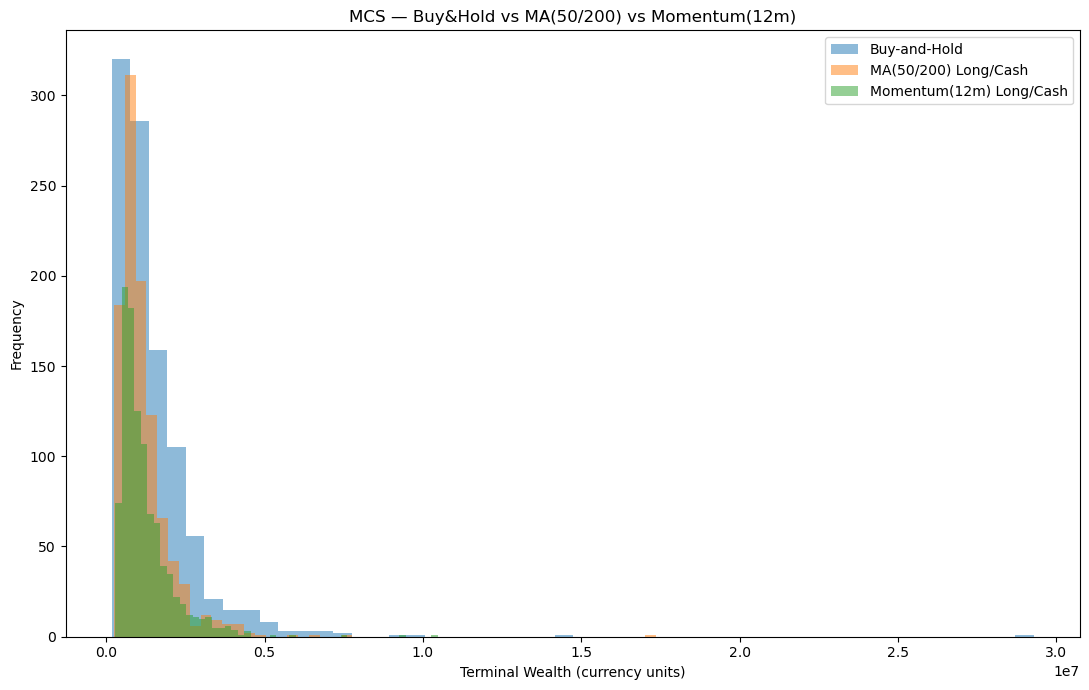

In [1]:

#!/usr/bin/env python3
"""
Market-Timing MCS: Buy-and-Hold vs 50/200d MA Crossover vs 12m Momentum

- Works with either real daily prices from CSV (date, close) or simulated GBM.
- Monte Carlo uses BLOCK BOOTSTRAP on daily returns to preserve path structure and
  recomputes signals on each synthetic path (avoiding look-ahead).
- Strategies are long-only. When out of market, capital sits in cash at a configurable
  risk-free rate (monthly compounding). No leverage, no shorts.

Outputs:
  - summary_mcs.csv         : Terminal wealth distribution stats per strategy
  - pairwise_mcs.csv        : B vs A outperformance probabilities and differences
  - wealth_hist_mcs.png     : Overlaid histograms of terminal wealth

Author: (your name)
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dataclasses import dataclass

# ------------------- CONFIG -------------------
CONFIG = {
    "data": {
        # Mode: "csv" (provide file) or "simulate"
        "mode": "simulate",  # change to "csv" when providing a file
        "csv_path": "prices.csv",  # expected columns: date, close (daily)
        # GBM fallback parameters (if mode = simulate)
        "gbm": {
            "annual_mu": 0.08,      # drift (e.g., 8% p.a.)
            "annual_sigma": 0.20,   # vol (e.g., 20% p.a.)
            "start_price": 100.0
        }
    },
    "simulation": {
        "months": 360,        # 30 years horizon
        "n_paths": 1000,      # Monte Carlo paths
        "block_days": 60,     # daily block size for bootstrap (~3 months of trading days)
        "seed": 42
    },
    "cash": {
        "annual_rf": 0.03     # cash/risk-free annual rate used when strategy is out of market
    },
    "contributions": {
        "base_monthly": 1000.0,
        "annual_raise": {"pct": 0.02, "apply_in_month": 1},  # January raise
        "bonus_months": [
            # Example: {"month": 12, "amount": 5000.0}
        ]
    },
    "outputs": {
        "summary_csv": "summary_mcs.csv",
        "pairs_csv": "pairwise_mcs.csv",
        "plot_png": "wealth_hist_mcs.png",
        "plot_title": "MCS — Buy&Hold vs MA(50/200) vs Momentum(12m)"
    }
}
# ---------------- END CONFIG ------------------


# ---------------- Utility Functions ----------------
def load_daily_prices(cfg) -> pd.Series:
    """
    Returns daily closing prices as a Series indexed by datetime.
    If mode='simulate', creates a synthetic daily GBM series for the requested horizon *with buffer*.
    """
    sim_cfg = CONFIG["simulation"]
    months = int(sim_cfg["months"])
    trading_days = int(months * 21)  # rough conversion (21 trading days per month)
    buffer_days = 400  # extra history for rolling windows (MA 200 + margin)

    mode = cfg["data"]["mode"]
    if mode == "csv":
        df = pd.read_csv(cfg["data"]["csv_path"])
        if "date" not in df.columns or "close" not in df.columns:
            raise ValueError("CSV must contain columns: 'date', 'close'.")
        px = pd.Series(df["close"].values,
                       index=pd.to_datetime(df["date"])).sort_index()
        return px
    elif mode == "simulate":
        gbm = cfg["data"]["gbm"]
        mu_a = float(gbm["annual_mu"])
        sig_a = float(gbm["annual_sigma"])
        S0 = float(gbm["start_price"])

        dt = 1.0/252.0
        mu_d = mu_a
        sig_d = sig_a
        n_days = trading_days + buffer_days

        np.random.seed(CONFIG["simulation"]["seed"])
        Z = np.random.normal(0, 1, size=n_days)
        # GBM: S_{t+1} = S_t * exp((mu - 0.5 sigma^2) dt + sigma sqrt(dt) Z)
        log_inc = (mu_d - 0.5*sig_d**2)*dt + sig_d*np.sqrt(dt)*Z
        S = np.zeros(n_days+1)
        S[0] = S0
        for t in range(n_days):
            S[t+1] = S[t] * np.exp(log_inc[t])

        idx = pd.date_range(start="2000-01-01", periods=n_days+1, freq="B")
        px = pd.Series(S, index=idx)
        return px
    else:
        raise ValueError("CONFIG['data']['mode'] must be 'csv' or 'simulate'.")


def to_monthly_returns_from_daily(px: pd.Series) -> pd.Series:
    px_m = px.resample("ME").last().dropna()
    r_m = px_m.pct_change().dropna().clip(lower=-0.99)
    return r_m


def monthly_cash_return(annual_rf: float) -> float:
    """Convert annual risk-free rate to flat monthly return."""
    return (1.0 + annual_rf)**(1.0/12.0) - 1.0


def make_contrib_vector(months: int, base: float,
                        annual_raise_pct: float = 0.0,
                        apply_in_month: int = 1,
                        bonus_months=None) -> np.ndarray:
    if bonus_months is None:
        bonus_months = []
    contrib = np.zeros(months)
    base_current = base
    for t in range(months):
        cal_m = (t % 12) + 1
        contrib[t] += base_current
        for bm in bonus_months:
            if int(bm.get("month", 0)) == cal_m:
                contrib[t] += float(bm.get("amount", 0.0))
        if cal_m == int(apply_in_month) and annual_raise_pct and t < months - 1:
            base_current *= (1.0 + annual_raise_pct)
    return contrib


# ---------------- Signals ----------------
def ma_crossover_exposure_daily(px: pd.Series, fast=50, slow=200) -> pd.Series:
    """
    Daily long-only exposure: 1 if MA(fast) > MA(slow), else 0.
    """
    ma_fast = px.rolling(fast, min_periods=fast).mean()
    ma_slow = px.rolling(slow, min_periods=slow).mean()
    exp_daily = (ma_fast > ma_slow).astype(int)
    return exp_daily


def monthly_exposure_from_daily_signal(exp_daily: pd.Series) -> pd.Series:
    """
    For each month, use the LAST daily signal of the PREVIOUS day (shift by 1 day to avoid look-ahead),
    then take the last signal in the month.
    """
    exp_shifted = exp_daily.shift(1)  # avoid look-ahead
    exp_m = exp_shifted.resample("ME").last().dropna().astype(int)
    exp_m = exp_m.ffill().fillna(0).astype(int)
    return exp_m


def momentum_exposure_monthly(px_m: pd.Series, lookback_months=12) -> pd.Series:
    """
    Monthly momentum: long if trailing 12m price change > 0, else 0.
    Signal is shifted by 1 month to avoid look-ahead.
    """
    mom = (px_m / px_m.shift(lookback_months)) - 1.0
    exp_m = (mom > 0).astype(int).shift(1).dropna()
    exp_m = exp_m.ffill().fillna(0).astype(int)
    return exp_m


# ---------------- Block Bootstrap (Daily) ----------------
def block_bootstrap_daily(daily_ret: pd.Series, n_days: int, block: int, rng: np.random.Generator) -> pd.Series:
    """
    Preserves daily dependence by concatenating random blocks.
    Returns a synthetic daily returns series of length n_days.
    """
    r = daily_ret.dropna().to_numpy()
    N = len(r)
    if N < block:
        raise ValueError(f"Insufficient history ({N} < block {block}).")
    max_start = N - block

    chunks = []
    total = 0
    while total < n_days:
        s = rng.integers(0, max_start + 1)
        chunk = r[s:s+block]
        chunks.append(chunk)
        total += len(chunk)

    out = np.concatenate(chunks, axis=0)[:n_days]
    idx = pd.date_range(start="1900-01-01", periods=n_days, freq="B")
    return pd.Series(out, index=idx)


def rebuild_price_from_returns(r_daily: pd.Series, S0: float) -> pd.Series:
    S = np.empty(len(r_daily) + 1)
    S[0] = S0
    for i, ret in enumerate(r_daily.values):
        S[i+1] = S[i] * (1.0 + ret)
    idx = pd.date_range(start=r_daily.index[0], periods=len(S), freq="B")
    return pd.Series(S, index=idx)


# ---------------- Strategies (monthly) ----------------
def apply_strategy_monthly(eq_r_m: pd.Series, exp_m: pd.Series, cash_r_m: float, contrib: np.ndarray) -> float:
    """
    Long-only timing strategy:
      monthly wealth W evolves by adding contribution, then applying return:
        If exposure==1: use equity monthly return
        Else: use cash monthly return (flat)
    Returns terminal wealth.
    """
    months = len(contrib)
    eq_r_m = eq_r_m.iloc[:months]
    exp_m = exp_m.iloc[:months]
    W = 0.0
    for t in range(months):
        W += contrib[t]
        ret = eq_r_m.iloc[t] if exp_m.iloc[t] == 1 else cash_r_m
        W *= (1.0 + ret)
    return float(W)


def apply_buy_and_hold_monthly(eq_r_m: pd.Series, contrib: np.ndarray) -> float:
    """
    Buy-and-hold: always fully invested in equity; monthly contribution then apply equity return.
    """
    months = len(contrib)
    eq_r_m = eq_r_m.iloc[:months]
    W = 0.0
    for t in range(months):
        W += contrib[t]
        W *= (1.0 + eq_r_m.iloc[t])
    return float(W)


# ---------------- Summaries ----------------
def summarize(x: np.ndarray) -> dict:
    return {
        "mean": float(np.mean(x)),
        "median": float(np.median(x)),
        "std": float(np.std(x, ddof=1)),
        "p5": float(np.percentile(x, 5)),
        "p25": float(np.percentile(x, 25)),
        "p75": float(np.percentile(x, 75)),
        "p95": float(np.percentile(x, 95)),
    }


# ---------------- Helpers ----------------
def ensure_len(s: pd.Series, months: int, fill=0):
    """
    Ensure 's' has exactly 'months' entries on a month-end index.
    If shorter, pad with the last value; if empty, create a fresh month-end index.
    """
    s = s.copy()

    # If index not DatetimeIndex, create a synthetic month-end index
    if not isinstance(s.index, pd.DatetimeIndex):
        start = pd.Timestamp("2001-01-31")
        s.index = pd.date_range(start=start, periods=len(s), freq="ME")

    # If not month-end frequency, coerce to month-end by resampling (take last)
    if s.index.freq is None or s.index.freqstr != "ME":
        s = s.resample("ME").last()

    # Trim if longer
    if len(s) >= months:
        return s.iloc[:months]

    # Pad if shorter
    if len(s) > 0:
        last_val = s.iloc[-1] if pd.notna(s.iloc[-1]) else fill
        start_next = s.index[-1] + pd.offsets.MonthEnd(1)
        pad_idx = pd.date_range(start=start_next, periods=(months - len(s)), freq="ME")
        add = pd.Series([last_val] * (months - len(s)), index=pad_idx)
        return pd.concat([s, add])
    else:
        start = pd.Timestamp("2001-01-31")
        idx = pd.date_range(start=start, periods=months, freq="ME")
        return pd.Series([fill] * months, index=idx)


# ---------------- Main Simulation ----------------
def run_mcs(cfg):
    # Load baseline daily prices (for signal calibration and bootstrap source)
    px_daily = load_daily_prices(cfg)

    # Daily returns from real/sim base
    r_daily = px_daily.pct_change().dropna().clip(lower=-0.99)

    # Configs
    months = int(cfg["simulation"]["months"])
    n_paths = int(cfg["simulation"]["n_paths"])
    block_days = int(cfg["simulation"]["block_days"])
    seed = int(cfg["simulation"]["seed"])
    cash_r_m = monthly_cash_return(float(cfg["cash"]["annual_rf"]))

    # Contribution schedule
    contrib = make_contrib_vector(
        months=months,
        base=float(cfg["contributions"]["base_monthly"]),
        annual_raise_pct=float(cfg["contributions"].get("annual_raise", {}).get("pct", 0.0)),
        apply_in_month=int(cfg["contributions"].get("annual_raise", {}).get("apply_in_month", 1)),
        bonus_months=cfg["contributions"].get("bonus_months", []),
    )

    rng = np.random.default_rng(seed)

    # Containers
    res_buy_hold = np.zeros(n_paths)
    res_ma = np.zeros(n_paths)
    res_mom = np.zeros(n_paths)

    # Monte Carlo loop
    for i in range(n_paths):
        # 1) Bootstrap daily returns and rebuild price path
        r_sim = block_bootstrap_daily(r_daily, n_days=months*21 + 250, block=block_days, rng=rng)
        S0 = float(px_daily.iloc[0])
        px_sim = rebuild_price_from_returns(r_sim, S0=S0)

        # 2) Signals on simulated path
        # MA crossover (daily), then monthly exposure
        exp_daily_ma = ma_crossover_exposure_daily(px_sim, fast=50, slow=200)
        exp_month_ma = monthly_exposure_from_daily_signal(exp_daily_ma)

        # Momentum exposure (monthly), derived from simulated monthly prices
        px_sim_m = px_sim.resample("ME").last().dropna()
        exp_month_mom = momentum_exposure_monthly(px_sim_m, lookback_months=12)

        # 3) Monthly returns of the simulated equity path
        eq_r_m = px_sim_m.pct_change().dropna().clip(lower=-0.99)

        # 4) Align series lengths (ensure we have 'months' observations)
        eq_r_m = ensure_len(eq_r_m, months, fill=0.0)
        exp_month_ma = ensure_len(exp_month_ma.astype(int), months, fill=0).astype(int)
        exp_month_mom = ensure_len(exp_month_mom.astype(int), months, fill=0).astype(int)

        # 5) Strategy terminal wealth
        res_buy_hold[i] = apply_buy_and_hold_monthly(eq_r_m, contrib)
        res_ma[i] = apply_strategy_monthly(eq_r_m, exp_month_ma, cash_r_m, contrib)
        res_mom[i] = apply_strategy_monthly(eq_r_m, exp_month_mom, cash_r_m, contrib)

    # Summaries
    summaries = []
    for name, arr in [("Buy-and-Hold", res_buy_hold),
                      ("MA(50/200) Long/Cash", res_ma),
                      ("Momentum(12m) Long/Cash", res_mom)]:
        sm = summarize(arr)
        sm["strategy"] = name
        summaries.append(sm)

    df_summary = pd.DataFrame(summaries).set_index("strategy")

    # Pairwise comparisons
    def pairwise(names, results_dict):
        pairs = []
        n = len(names)
        for i in range(n):
            for j in range(i+1, n):
                A, B = names[i], names[j]
                X, Y = results_dict[A], results_dict[B]
                pairs.append({
                    "A": A,
                    "B": B,
                    "prob_B_outperforms_A": float(np.mean(Y > X)),
                    "avg_B_minus_A": float(np.mean(Y - X)),
                    "median_B_minus_A": float(np.median(Y - X))
                })
        return pd.DataFrame(pairs)

    results = {
        "Buy-and-Hold": res_buy_hold,
        "MA(50/200) Long/Cash": res_ma,
        "Momentum(12m) Long/Cash": res_mom
    }
    names = list(results.keys())
    df_pairs = pairwise(names, results)

    # Plot
    plt.figure(figsize=(11, 7))
    colors = ["#1f77b4","#ff7f0e","#2ca02c"]
    for (name, arr), c in zip(results.items(), colors):
        plt.hist(arr, bins=50, alpha=0.5, label=name, color=c)
    plt.xlabel("Terminal Wealth (currency units)")
    plt.ylabel("Frequency")
    plt.title(CONFIG["outputs"]["plot_title"])
    plt.legend()
    plt.tight_layout()
    plt.savefig(CONFIG["outputs"]["plot_png"], dpi=160)

    # Write outputs
    df_summary.to_csv(CONFIG["outputs"]["summary_csv"])
    df_pairs.to_csv(CONFIG["outputs"]["pairs_csv"], index=False)

    print("\n=== Strategy Summary (Terminal Wealth) ===")
    print(df_summary.to_string(float_format=lambda x: f"{x:,.2f}"))
    print("\n=== Pairwise Outperformance (B vs A) ===")
    print(df_pairs.to_string(index=False, float_format=lambda x: f"{x:,.4f}"))
    print("\nWrote files:")
    print(f" - {CONFIG['outputs']['summary_csv']}")
    print(f" - {CONFIG['outputs']['pairs_csv']}")
    print(f" - {CONFIG['outputs']['plot_png']}")


if __name__ == "__main__":
    run_mcs(CONFIG)
